In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda")

In [4]:
mnist_train = torchvision.datasets.MNIST("/tmp/training.pt", train=True, download=True, transform=torchvision.transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST("/tmp/test.pt", train=False, download=True, transform=torchvision.transforms.ToTensor())

In [5]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1000, shuffle=True)

In [6]:
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Dropout(0.25),
    nn.Flatten(),
    nn.Linear(9216, 128),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1),
).to(device)

optimizer = optim.Adadelta(model.parameters())

In [7]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(5 + 1)]

In [8]:
def train(network, epoch, log_interval=100):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
        train_losses.append(loss.item())
        train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

def test(network):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += F.nll_loss(output, target.to(device), size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print("\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
        test_loss, correct, len(test_loader.dataset),
        100.0 * correct / len(test_loader.dataset)
    ))

In [9]:
test(model)

/home/mahowald/miniconda3/envs/academy/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3012, Accuracy: 1010/10000 (10%)



In [10]:
test(model)
for epoch in range(1, 6):
    train(model, epoch)
    test(model)


Test set: Avg. loss: 2.3012, Accuracy: 1010/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303124
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.540368
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.281917
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.105534
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.064929
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.214965
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.100998
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.039401
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.072721
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.343501

Test set: Avg. loss: 0.0520, Accuracy: 9844/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.061372
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.172254
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.101705
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.122392
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.067539
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.245676
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.109036
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.229

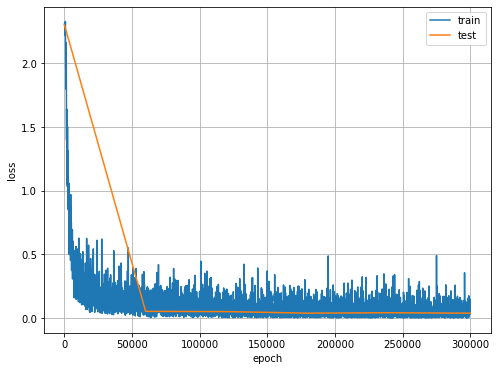

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))

plt.plot(train_counter, train_losses, label="train")
plt.plot(test_counter, test_losses[1:], label="test")

ax.legend()
ax.grid()
ax.set_xlabel("epoch")
ax.set_ylabel("loss")

plt.show()

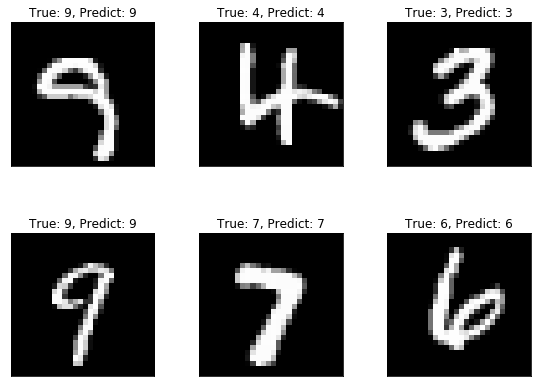

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(8, 6))
plt.tight_layout()

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
predictions = model(example_data.to(device))

i = 0
for row in ax:
    for col in row:
        col.imshow(example_data[i][0], cmap='gray', interpolation='none')
        col.set_title("True: {}, Predict: {}".format(example_targets[i], predictions[i].argmax()))
        col.set_xticks([])
        col.set_yticks([])
        i += 1

plt.show()